In [1]:
import cv2
import mtcnn
from keras_facenet import FaceNet
import warnings
import faiss
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.preprocessing import StandardScaler
import dlib

warnings.filterwarnings("ignore")

In [2]:
# Initialize MTCNN Face Detector
detector = mtcnn.MTCNN()

# Initialize FaceNet Embedding Model
model = FaceNet()

In [3]:
face_detector = dlib.get_frontal_face_detector()  # Create the detector

In [4]:
# -------- Image Augmentation Function --------
def apply_augmentations(image):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            sometimes(iaa.CropAndPad(percent=(-0.1, 0.1))),
            sometimes(iaa.Affine(rotate=(-15, 15))),
            sometimes(iaa.Fliplr(0.5)),
            sometimes(iaa.GaussianBlur(sigma=(0, 0.5))),
            sometimes(iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255))),
            sometimes(iaa.ContrastNormalization((0.75, 1.25))),
        ]
    )
    return seq(image=image)

In [5]:
# -------- Face Extraction Function --------
def extract_face(filename=None, image_pixels=None, required_size=(160, 160)):
    if filename is not None:
        image = Image.open(filename)
        image = image.convert("RGB")
        pixels = np.asarray(image)
    elif image_pixels is not None:
        pixels = image_pixels

    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]["box"]
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    box_dimensions = (x1, y1, width, height)
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array, box_dimensions

### **Task 1.** loading datset and creating embeddings

In [6]:
# -------- Functions to Load Dataset, Calculate Embeddings --------
def load_faces(directory):
    faces = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        face, _ = extract_face(filename=path)
        face = apply_augmentations(face)  # Apply augmentations
        faces.append(face)
    return faces


def load_dataset(directory):
    X, y = [], []
    for subdir in os.listdir(directory):
        path = os.path.join(directory, subdir)
        if not os.path.isdir(path):
            continue
        faces = load_faces(path)
        labels = [subdir for _ in range(len(faces))]
        print(f"Loaded {len(faces)} examples for class: {subdir}")
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [7]:
def calculate_embeddings(model, faces, batch_size=32):
    num_faces = len(faces)
    embeddings = []

    for start_idx in range(0, num_faces, batch_size):
        end_idx = min(start_idx + batch_size, num_faces)
        batch = faces[start_idx:end_idx]
        batch_embeddings = model.embeddings(batch)
        embeddings.extend(batch_embeddings)

    return np.array(embeddings)

In [30]:
# -------- Train/Test Dataset Paths --------
train_dataset_path = r"M:/14-celebrity-faces-dataset/data/train"
test_dataset_path = r"M:/14-celebrity-faces-dataset/data/val"

# -------- Load Datasets and Calculate Embeddings --------
train_faces, train_labels = load_dataset(train_dataset_path)
train_embeddings = calculate_embeddings(model, train_faces)

test_faces, test_labels = load_dataset(test_dataset_path)
test_embeddings = calculate_embeddings(model, test_faces)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [13]:
# # -------- Embedding Standardization --------
# scaler = StandardScaler()
# train_embeddings = scaler.fit_transform(train_embeddings)
# test_embeddings = scaler.transform(test_embeddings)

In [31]:
def store_embeddings(embeddings, labels, filename):
    with h5py.File(filename, "w") as f:
        f.create_dataset("embeddings", data=embeddings, compression="gzip")
        # Convert labels to bytes before storing
        labels_as_bytes = [label.encode("utf-8") for label in labels]
        f.create_dataset("labels", data=labels_as_bytes, compression="gzip")

In [36]:
store_embeddings(train_embeddings, train_labels, "train_embeddings_copy.h5")
store_embeddings(test_embeddings, test_labels, "test_embeddings_copy.h5")

### **Load saved embeddings**

In [8]:
def load_embeddings(filename):
    with h5py.File(filename, "r") as f:
        embeddings = f["embeddings"][:]
        labels = [label.decode("utf-8") for label in f["labels"][:]]
    return embeddings, labels

In [9]:
print("Loading train embeddings...")
train_embeddings, labels = load_embeddings("train_embeddings_copy.h5")
print("Loading test embeddings...")
test_embeddings, test_labels = load_embeddings("test_embeddings_copy.h5")

Loading train embeddings...
Loading test embeddings...


### **Task2.** Real-time face recognition

In [10]:
# -------- Faiss Indexing --------
emebeddings = train_embeddings

dimensions = emebeddings.shape[1]

index = faiss.IndexFlatL2(dimensions)

index.add(emebeddings)

In [11]:
# Function to get the face embedding
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    samples = np.expand_dims(face_pixels, axis=0)
    yhat = model.model.predict(samples)
    return yhat[0]

#### Video

In [21]:
import dlib

# Load the video
video = cv2.VideoCapture(0)  # Assuming you want to use your webcam

face_detector = dlib.get_frontal_face_detector()  # Create the detector

while True:
    ret, frame = video.read()  # Read the frame

    if not ret:  # Check if a frame was successfully read
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray, 1)  # Detect faces (upsample 1 time)

    # Draw rectangles around the detected faces
    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        # Extract and preprocess face
        face_roi = frame[y : y + h, x : x + w]
        resized_face = cv2.resize(face_roi, (160, 160))
        rgb_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB)  # Convert to RGB
        normalized_face = rgb_face / 255.0  # Normalize

        # Calculate the embedding
        face_embedding = get_embedding(model, normalized_face)

        # Find the closest match (top 5 for flexibility)
        distances, indices = index.search(face_embedding.reshape(1, -1), k=5)

        # Display the top match (or "Unknown" if confidence is low)
        top_match_index = indices[0][0]
        top_match_distance = distances[0][0]

        if top_match_distance < 0.8:  # Example threshold - adjust as needed
            matching_label = labels[top_match_index]
        else:
            matching_label = "Unknown"

        cv2.putText(
            frame,
            matching_label,
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.75,
            (0, 255, 0),
            2,
        )

    # Display the frame
    cv2.imshow("Face Detection", frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
video.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


: 

### Face detection and recognition from still images

In [15]:
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Failed to load image:", image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Face detection and matching for a single image
def process_image(image_path, top_k=5, target_size=(160, 160)):  # Added target_size
    image = load_image(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_detector(gray, 1)

    for face in faces:
        x, y, w, h = face.left(), face.top(), face.width(), face.height()

        # Extract and preprocess
        face_roi = image[y : y + h, x : x + w]

        # Resize before calculating the embedding
        resized_face = cv2.resize(face_roi, target_size)  # Resize to target_size

        normalized_face = resized_face / 255.0
        face_embedding = get_embedding(model, normalized_face)
        # print(face_embedding)

        # Find matches
        distances, indices = index.search(face_embedding.reshape(1, -1), k=top_k)

        # Display matches
        for i in range(top_k):
            distance = distances[0][i]
            match_index = indices[0][i]
            match_label = labels[match_index]
            # print(distance, match_index, match_label)

            if distance < 1:  # Threshold - adjust as needed
                print(f"Match: {match_label}, Distance: {distance:.2f}")
            else:
                print("Unknown")

        # Draw rectangle (optional)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # Save the image
        output_filename = "output_image.jpg"  # Change the name as needed
        cv2.imwrite(output_filename, image) 
        # print(f"Image with bounding boxes saved as {output_filename}")

    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)  # Create a resizable window
    cv2.imshow("Image", image)
    # Adjust this for the maximum dimensions of the display window
    max_width = 800
    max_height = 600
    # Calculate a scaling factor based on the image dimensions and the maximum dimensions
    scale_width = max_width / image.shape[1]
    scale_height = max_height / image.shape[0]
    scale = min(scale_width, scale_height)
    # Resize the window
    window_width = int(image.shape[1] * scale)
    window_height = int(image.shape[0] * scale)
    cv2.resizeWindow("Image", window_width, window_height)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


image_path = r"K:/data/val/multi.jpg"
process_image(image_path, target_size=(160, 160))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Match: keanu_reeves, Distance: 0.95
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Match: badal, Distance: 0.96
Match: vishu, Distance: 0.99
Match: badal, Distance: 1.00
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Unknown
Unknown
Unknown
Unknown
Unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Match: badal, D

### **Performance Evaluation**

In [16]:
import sklearn.metrics as metrics
from scipy import integrate

# ... (Load your datasets, embeddings, and labels)

# ... (Create your Faiss index - Assume the name of your index is 'index')

# Matching and Evaluation
predictions = []

for test_embedding in test_embeddings:
    distances, indices = index.search(
        test_embedding.reshape(1, -1), k=1
    )  # Find the closest match
    top_match_index = indices[0][0]
    predicted_label = labels[top_match_index]
    predictions.append(predicted_label)

# Metric Calculation
accuracy = metrics.accuracy_score(test_labels, predictions)
precision = metrics.precision_score(test_labels, predictions, average="weighted")
recall = metrics.recall_score(test_labels, predictions, average="weighted")
f1 = metrics.f1_score(test_labels, predictions, average="weighted")

# fpr, tpr, _ = metrics.roc_curve(test_labels, predictions)
# roc_auc = integrate.trapz(tpr, fpr)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
# print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9863
Precision: 0.9886
Recall: 0.9863
F1-Score: 0.9862


In [17]:
confusion_matrix = metrics.confusion_matrix(test_labels, predictions)
print(confusion_matrix)

[[6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]


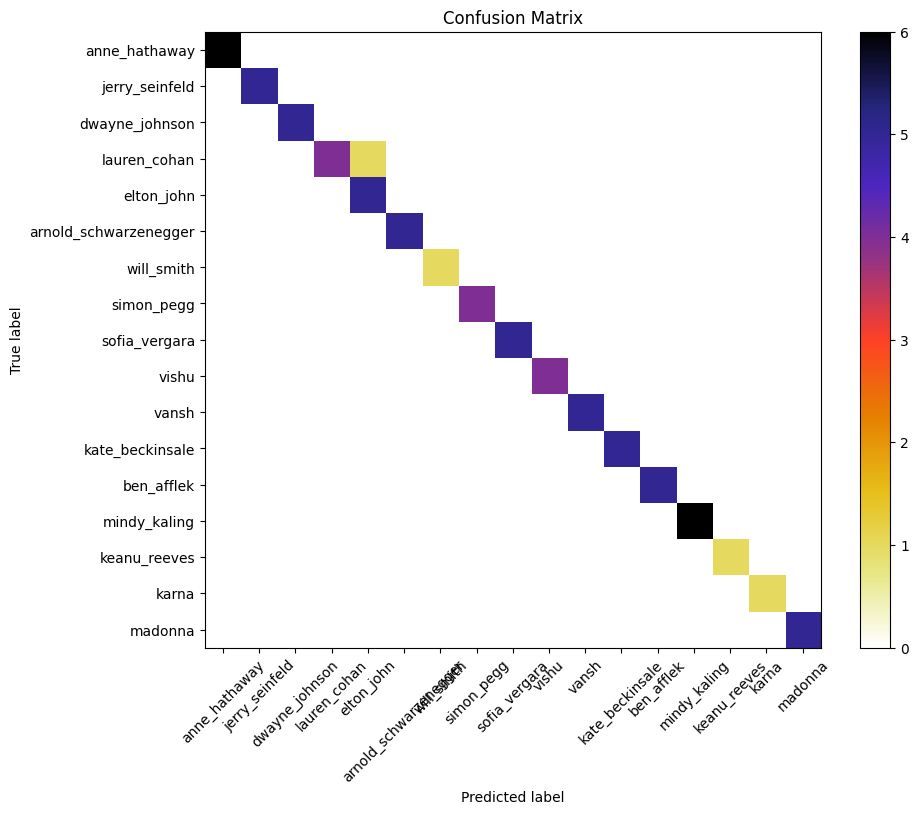

In [18]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.get_cmap("CMRmap_r"))
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(set(test_labels)))
plt.xticks(tick_marks, set(test_labels), rotation=45)
plt.yticks(tick_marks, set(test_labels))

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

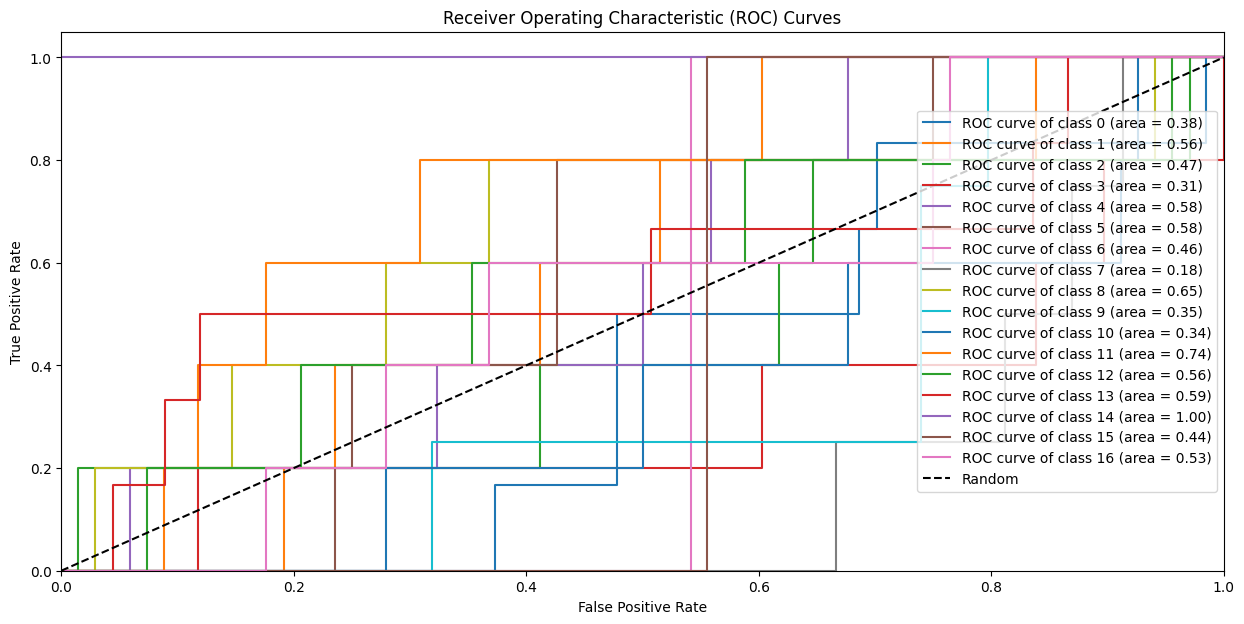

In [20]:
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


# # Binarize labels for One-vs-Rest
y_test = label_binarize(test_labels, classes=np.unique(test_labels))
n_classes = y_test.shape[1]


unique_labels = np.unique(test_labels)
y_test = label_binarize(test_labels, classes=unique_labels)


# Placeholder for individual class scores
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC-AUC for each class
for i in range(n_classes):
    k = 1  # Retrieve the single nearest neighbor
    distances = index.search(test_embeddings, k)[0][:, 0]  # Extract distances
    y_score = distances  # Use distances as scores

    # Optionally invert scores (smaller distance -> higher score)
    y_score = 1.0 / y_score

    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score)
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute macro-average ROC-AUC (weighted by class size)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

macro_roc_auc = metrics.auc(all_fpr, mean_tpr)


plt.figure(figsize=(15, 7))
# Plot ROC curves
# plt.figure()
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"ROC curve of class {i} (area = {roc_auc[i]:.2f})",
    )


plt.plot([0, 1], [0, 1], "k--", label="Random")  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curves")
plt.legend(loc="right")
plt.show()